**Baseline Model - Machine translation using Encoder Decoder (seq to seq) with attention mechanism**

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%cd /content/drive/My Drive/NLP_Project/

/content/drive/My Drive/NLP_Project


In [3]:
import torch
import re

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

**Data preprocessing**

In [5]:
with open('europarl-v7.sv-en.en') as src, open('europarl-v7.sv-en.sv') as tgt:
  for i, src_sentence, tgt_sentence in zip(range(5), src, tgt):
    print(f'{i}: {src_sentence.rstrip()} / {tgt_sentence.rstrip()}')

0: Resumption of the session / Återupptagande av sessionen
1: I declare resumed the session of the European Parliament adjourned on Friday 17 December 1999, and I would like once again to wish you a happy new year in the hope that you enjoyed a pleasant festive period. / Jag förklarar Europaparlamentets session återupptagen efter avbrottet den 17 december. Jag vill på nytt önska er ett gott nytt år och jag hoppas att ni haft en trevlig semester.
2: Although, as you will have seen, the dreaded 'millennium bug' failed to materialise, still the people in a number of countries suffered a series of natural disasters that truly were dreadful. / Som ni kunnat konstatera ägde "den stora år 2000-buggen" aldrig rum. Däremot har invånarna i ett antal av våra medlemsländer drabbats av naturkatastrofer som verkligen varit förskräckliga.
3: You have requested a debate on this subject in the course of the next few days, during this part-session. / Ni har begärt en debatt i ämnet under sammanträdesper

**Get the first 200000 <english , swedish> sentences pair for the training data**

In [ ]:
f = open("trainX.txt", "w+")
g = open("trainY.txt", "w+")
total = 0
with open('europarl-v7.sv-en.en', 'rt', encoding='utf-8') as fp:
    with open('europarl-v7.sv-en.sv', 'rt', encoding='utf-8') as gp:
        for line1, line2 in zip(fp, gp):
            if len(line1) > 1 and len(line2) > 1:
                f.write(line1)
                g.write(line2)
                total += 1
                if total == 200000:
                    break

**Get the next 1000 <english, swedish > sentences pairs as validitaion data**

In [ ]:
f2 = open("validX.txt", "w+")
g2 = open("validY.txt", "w+")
total = 0
with open('europarl-v7.sv-en.en', 'rt', encoding='utf-8') as fp:
    with open('europarl-v7.sv-en.sv', 'rt', encoding='utf-8') as gp:
        for i, line1, line2 in zip(range(500000), fp, gp):
            if len(line1) > 1 and len(line2) > 1:
                if i>=200000:
                    f2.write(line1)
                    g2.write(line2)
                    total += 1
                    if total == 1000:
                        break

**Truncate max length of sentences to 20 before yielding it!**

**To replicate the results run after this line of code**

In [45]:
def sentences(filename, max_length=20):
  with open(filename) as fp:
    for line in fp:
      sentence = line.rstrip().split()
      yield sentence[:max_length]

In [46]:
s = sentences('trainX.txt')
for i, sent in enumerate(s):
  for word in sent:
    print(word)
  print('\n')
  if i == 3:
    break

Resumption
of
the
session


I
declare
resumed
the
session
of
the
European
Parliament
adjourned
on
Friday
17
December
1999,
and
I
would
like
once


Although,
as
you
will
have
seen,
the
dreaded
'millennium
bug'
failed
to
materialise,
still
the
people
in
a
number
of


You
have
requested
a
debate
on
this
subject
in
the
course
of
the
next
few
days,
during
this
part-session.




In [47]:
eng = next(iter(sentences('trainX.txt')))

In [48]:
eng

['Resumption', 'of', 'the', 'session']

In [49]:
from collections import Counter

In [50]:
PAD = '<pad>'
BOS = '<bos>'
EOS = '<eos>'
UNK = '<unk>'

def make_vocab(sentences, max_size):
  # TODO: Replace the next line with your own code
  vocab = {}
  vocab[PAD] = len(vocab)
  vocab[BOS] = len(vocab)
  vocab[EOS] = len(vocab)
  vocab[UNK] = len(vocab)

  L = []
  for sent in sentences:
    for word in sent:
      L.append(word)

  most_freq = Counter(L).most_common() 

  for i in range(max_size-4):
    vocab[most_freq[i][0]] = len(vocab)

  return vocab


In [51]:
src_vocab = make_vocab(sentences('trainX.txt'), 2**14)
tgt_vocab = make_vocab(sentences('trainY.txt'), 2**14)

In [52]:
print(len(src_vocab), ',', len(tgt_vocab))

16384 , 16384


In [53]:
from torch.utils.data import Dataset

class TranslationDataset(Dataset):

    def __init__(self, src_vocab, src_filename, tgt_vocab, tgt_filename):
        self.src_vocab = src_vocab
        self.tgt_vocab = tgt_vocab

        # We hard-wire the codes for <bos> (1), <eos> (2), and <unk> (3).
        self.src = [[self.src_vocab.get(w, 3) for w in s] for s in sentences(src_filename)]
        self.tgt = [[self.tgt_vocab.get(w, 3) for w in s] + [2] for s in sentences(tgt_filename)]

    def __getitem__(self, idx):
        return self.src[idx], self.tgt[idx]

    def __len__(self):
        return len(self.src)

In [54]:
train_dataset = TranslationDataset(src_vocab, 'trainX.txt', tgt_vocab, 'trainX.txt')

In [55]:
def example(dataset, i):
    src, tgt = dataset[i]
    return torch.LongTensor(src).unsqueeze(0), torch.LongTensor(tgt).unsqueeze(0)

In [56]:
example(train_dataset, 0)

(tensor([[6714,    6,    4, 1667]]), tensor([[   3, 3328, 3189, 3165,    2]]))

In [57]:
len(train_dataset)

200000

In [58]:
import torch.nn as nn

class Encoder(nn.Module):

  def __init__(self, num_words, embedding_dim=256, hidden_dim=512):
    super().__init__()
    # TODO: Add your code here
    self.embedding = nn.Embedding(num_words, embedding_dim)
    self.rnn = nn.GRU(embedding_dim, hidden_dim, batch_first=True, bidirectional=True)
    self.fc_hidden = nn.Linear(hidden_dim * 2, hidden_dim)

  def forward(self, src):
    # TODO: Replace the next line with your own code
    embedding = self.embedding(src)
    #print(embedding.shape) # [1, 13, 256]

    outputs, hidden = self.rnn(embedding)
    #print(hidden.shape) # [2, 1, 512]

    h = self.fc_hidden(torch.cat((hidden[-1], hidden[-2]), dim=1))

    #h = self.fc_hidden(torch.cat((hidden[0:1], hidden[1:2]), dim=2))
    
    #h = self.fc_hidden(torch.cat((hidden[0:hidden.size(0):2], hidden[1:hidden.size(0):2]), dim=2))

    return outputs, h

In [59]:
source = example(train_dataset, 1)[0]
src_mask = (source != 0)

In [60]:
enc = Encoder(len(src_vocab))
out, hid = enc.forward(source)
print(out.shape, ',', hid.shape)

torch.Size([1, 20, 1024]) , torch.Size([1, 512])


In [61]:
import torch.nn.functional as F

class BahdanauAttention(nn.Module):

    def __init__(self, hidden_dim=512):
        super().__init__()
        # TODO: Add your code here
        self.key_layer = nn.Linear(2 * hidden_dim, hidden_dim, bias=False)
        self.query_layer = nn.Linear(hidden_dim, hidden_dim, bias=False)
        self.energy_layer = nn.Linear(hidden_dim, 1, bias=False)

    def forward(self, decoder_hidden, encoder_output, src_mask):
        batch_size, src_len, _ = encoder_output.shape

        # TODO: Replace the next line with your own code
        query = decoder_hidden.unsqueeze(1)
        #print(query.shape) # [1, 1, 512]

        key = encoder_output
        #print(key.shape) # [1, 13, 1024]

        #scores = torch.zeros(batch_size, src_len, device=encoder_output.device)
        #print(scores.shape)

        scores = self.energy_layer(torch.tanh(self.query_layer(query) + self.key_layer(key)))
        #print(scores.shape)  # [1, 13, 1]

        scores = scores.squeeze(2)
        #print(scores.shape) # [1, 13]

        
        # The rest of the code is as in UniformAttention

        # Mask out the attention scores for the padding tokens. We set
        # them to -inf. After the softmax, we will have 0.
        scores.data.masked_fill_(~src_mask, -float('inf'))
        

        # Convert scores into weights
        alpha = F.softmax(scores, dim=1)
        #print(alpha.shape)

        # The context vector is the alpha-weighted sum of the encoder outputs.
        context = torch.bmm(alpha.unsqueeze(1), encoder_output).squeeze(1)

        return context, alpha

In [62]:
att = BahdanauAttention()
c, a = att.forward(hid, out, src_mask)

In [63]:
print(c.shape, ',', a.shape)

torch.Size([1, 1024]) , torch.Size([1, 20])


In [64]:
class Decoder(nn.Module):

    def __init__(self, num_words, attention, embedding_dim=256, hidden_dim=512):
        super().__init__()
        self.embedding = nn.Embedding(num_words, embedding_dim)
        self.attention = attention
        # TODO: Add your own code
        self.rnn = nn.GRU(embedding_dim + 2 * hidden_dim, hidden_dim, batch_first=True)
        self.f_output = nn.Linear(hidden_dim + 2*hidden_dim + embedding_dim, num_words)

    def forward(self, encoder_output, hidden, src_mask, tgt):
        batch_size, tgt_len = tgt.shape

        # Lookup the embeddings for the previous words
        embedded = self.embedding(tgt)

        # Initialise the list of outputs (in each sentence)
        outputs = []

        for i in range(tgt_len):
            # Get the embedding for the previous word (in each sentence)
            prev_embedded = embedded[:, i]

            # Take one step with the RNN
            output, hidden, alpha = self.step(encoder_output, hidden, src_mask, prev_embedded)

            # Update the list of outputs (in each sentence)
            outputs.append(output.unsqueeze(1))

        return torch.cat(outputs, dim=1)

    def decode(self, encoder_output, hidden, src_mask, max_len):
        batch_size = encoder_output.size(0)

        # Initialise the list of generated words and attention weights (in each sentence)
        generated = [torch.ones(batch_size, dtype=torch.long, device=hidden.device)]
        alphas = []

        for i in range(max_len):
            # Get the embedding for the previous word (in each sentence)
            prev_embedded = self.embedding(generated[-1])

            # Take one step with the RNN
            output, hidden, alpha = self.step(encoder_output, hidden, src_mask, prev_embedded)

            # Update the list of generated words and attention weights (in each sentence)
            generated.append(output.argmax(-1))
            alphas.append(alpha)

        generated = [x.unsqueeze(1) for x in generated[1:]]
        alphas = [x.unsqueeze(1) for x in alphas]
            
        return torch.cat(generated, dim=1), torch.cat(alphas, dim=1)

    def step(self, encoder_output, hidden, src_mask, prev_embedded):
        # TODO: Replace the next line with your own code

        context_vec, alphas = self.attention(hidden, encoder_output, src_mask)
        #print(context_vec.shape, ',', prev_embedded.shape) # [1, 1024] , [1, 256]

        rnn_input = torch.cat((prev_embedded, context_vec), dim=1)
        #print(rnn_input.shape) # [1, 1280]
    
        output, hid = self.rnn(rnn_input.unsqueeze(1), hidden.unsqueeze(0))
        #print(output.shape, '+', hidden.shape) # [1, 1, 512] , [1, 1, 512]

        pre_output = torch.cat((prev_embedded, output.squeeze(1), context_vec), dim=1)
        #print(pre_output.shape)  # [1, 1792]

        pred = self.f_output(pre_output)
        #print(pred.shape, '+', hid.squeeze(0).shape, '+', alphas.shape)  # [1, 10000] , [1, 512] , [1, 13]

        return pred, hid.squeeze(0), alphas

In [65]:
import sys
target = example(train_dataset, 1)[1]
target

tensor([[   43,     3,     3,  3189,  3165,  3328,  3189,  9631,     3,     3,
         13872,     3,  1976,     3,  2318,  5261,    43,     3,     3,     3,
             2]])

In [66]:
dec = Decoder(len(tgt_vocab), att)
dec.forward(out, hid, src_mask, target)

tensor([[[ 0.5960,  0.1343, -0.0103,  ...,  0.0488, -0.1337,  0.0911],
         [-0.2894,  0.2555, -0.2994,  ..., -0.4722,  0.0226,  0.0611],
         [-0.3208,  0.2408, -0.2947,  ..., -0.4989,  0.0047,  0.0914],
         ...,
         [-0.3616,  0.2269, -0.3074,  ..., -0.4931, -0.0031,  0.1013],
         [-0.3577,  0.2151, -0.2989,  ..., -0.5114, -0.0132,  0.1055],
         [ 0.0828,  0.1629,  0.4624,  ..., -0.3276, -0.0742, -0.0223]]],
       grad_fn=<CatBackward>)

In [67]:
class EncoderDecoder(nn.Module):

    def __init__(self, src_vocab_size, tgt_vocab_size, attention):
        super().__init__()
        self.encoder = Encoder(src_vocab_size)
        self.decoder = Decoder(tgt_vocab_size, attention)

    def forward(self, src, tgt):
        encoder_output, hidden = self.encoder(src)
        return self.decoder.forward(encoder_output, hidden, src != 0, tgt)

    def decode(self, src, max_len):
        encoder_output, hidden = self.encoder(src)
        return self.decoder.decode(encoder_output, hidden, src != 0, max_len)

In [68]:
ed = EncoderDecoder(len(src_vocab), len(tgt_vocab), att)
ed.forward(source, target)

tensor([[[-0.2558, -0.2744,  0.5623,  ..., -0.5561,  0.0736, -0.4526],
         [ 0.2086,  0.1849,  0.2977,  ...,  0.4356,  0.3550, -0.0873],
         [ 0.2077,  0.2343,  0.2990,  ...,  0.4226,  0.3964, -0.0633],
         ...,
         [ 0.2101,  0.2236,  0.2612,  ...,  0.4173,  0.4168, -0.0504],
         [ 0.2016,  0.2543,  0.2657,  ...,  0.4037,  0.4317, -0.0379],
         [ 0.1523,  0.1149, -0.1494,  ...,  0.1221,  0.1785, -0.0928]]],
       grad_fn=<CatBackward>)

In [69]:
#encoded = [[self.src_vocab.get(w, 3) for w in s.split()] for s in sentences]
src_vocab.get('day', 3)

941

In [70]:
src_vocab

{'<pad>': 0,
 '<bos>': 1,
 '<eos>': 2,
 '<unk>': 3,
 'the': 4,
 'to': 5,
 'of': 6,
 'and': 7,
 'in': 8,
 'is': 9,
 'that': 10,
 'a': 11,
 'I': 12,
 'for': 13,
 'on': 14,
 'this': 15,
 'we': 16,
 'be': 17,
 'are': 18,
 'The': 19,
 'have': 20,
 'not': 21,
 'it': 22,
 'which': 23,
 'Mr': 24,
 'as': 25,
 'with': 26,
 'will': 27,
 'has': 28,
 'by': 29,
 'European': 30,
 'We': 31,
 'would': 32,
 'should': 33,
 'must': 34,
 'President,': 35,
 'also': 36,
 'It': 37,
 'at': 38,
 'Commission': 39,
 'an': 40,
 'In': 41,
 'been': 42,
 'from': 43,
 'This': 44,
 'like': 45,
 'all': 46,
 'our': 47,
 'but': 48,
 'was': 49,
 'you': 50,
 'can': 51,
 's': 52,
 'there': 53,
 'do': 54,
 '-': 55,
 'very': 56,
 'these': 57,
 'report': 58,
 'more': 59,
 'my': 60,
 'about': 61,
 'what': 62,
 'its': 63,
 'Member': 64,
 'or': 65,
 'Parliament': 66,
 'Council': 67,
 'one': 68,
 'am': 69,
 'need': 70,
 'only': 71,
 'they': 72,
 'if': 73,
 'no': 74,
 'important': 75,
 'other': 76,
 'their': 77,
 'Union': 78,
 'who'

In [71]:
class Translator(object):

    def __init__(self, src_vocab, tgt_vocab, attention, device=torch.device('cpu')):
        self.src_vocab = src_vocab
        self.tgt_vocab = tgt_vocab
        self.device = device
        self.model = EncoderDecoder(len(src_vocab), len(tgt_vocab), attention).to(device)

    def translate_with_attention(self, sentences):
        # Encode each sentence

        encoded = [[self.src_vocab.get(w, 3) for w in s.split()] for s in sentences]

        # Determine the maximal length of an encoded sentence

        max_len = max(len(e) for e in encoded)

        # Build the input tensor, padding all sequences to the same length
        src = torch.LongTensor([e + [0] * (max_len - len(e)) for e in encoded]).to(self.device)

        # Run the decoder and convert the result into nested lists
        with torch.no_grad():
            decoded, alphas = tuple(d.cpu().numpy().tolist() for d in self.model.decode(src, 2 * max_len))

        # Prune each decoded sentence after the first <eos>
        i2w = {i: w for w, i in self.tgt_vocab.items()}
        result = []
        for d, a in zip(decoded, alphas):
            d = [i2w[i] for i in d]
            try:
                eos_index = d.index('<eos>')
                del d[eos_index:]
                del a[eos_index:]
            except:
                pass
            result.append((' '.join(d), a))

        return result

    def translate(self, sentences):
        translated, alphas = zip(*self.translate_with_attention(sentences))
        return translated

In [72]:
translator = Translator(src_vocab, tgt_vocab, BahdanauAttention())
translator.translate(['This is an important matter', 'Resumption of the session'])

('djur, permanenta utfärdade tittade aktuella journalister statens reaktioner betrakta tvingas',
 'Tro marknadsföring form. subventioner tanke makten, bin infrastruktur rapporten. förordning')

In [73]:
!pip install sacrebleu

     |████████████████████████████████| 71kB 5.1MB/s 


In [74]:
import sacrebleu

def bleu(translator, src, ref):
    translated = translator.translate(src)
    return sacrebleu.raw_corpus_bleu(translated, [ref], 0.01).score

In [75]:
with open('validX.txt') as src, open('validY.txt') as ref:
    valid_src = [line.rstrip() for line in src]
    valid_ref = [line.rstrip() for line in ref]

In [76]:
len(valid_src)

1000

In [77]:
class TranslationBatcher(object):

    def __init__(self, device):
        self.device = device

    def __call__(self, batch):
        srcs, tgts = zip(*batch)

        # Determine the maximal length of a source/target sequence
        max_src_len = max(len(s) for s in srcs)
        max_tgt_len = max(len(t) for t in tgts)

        # Create the source/target tensors
        S = torch.LongTensor([s + [0] * (max_src_len - len(s)) for s in srcs])
        T = torch.LongTensor([t + [0] * (max_tgt_len - len(t)) for t in tgts])

        return S.to(self.device), T.to(self.device)

In [85]:
from torch.utils.data import DataLoader
from tqdm import tqdm

def train(n_epochs=2, batch_size=128, lr=5e-4):
    # Build the vocabularies
    vocab_src = make_vocab(sentences('trainX.txt'), 2**14)
    vocab_tgt = make_vocab(sentences('trainY.txt'), 2**14)

    # Prepare the dataset
    train_dataset = TranslationDataset(vocab_src, 'trainX.txt', vocab_tgt, 'trainY.txt')

    # Prepare the data loaders
    batcher = TranslationBatcher(device)
    train_loader = DataLoader(train_dataset, batch_size, shuffle=True, collate_fn=batcher)

    # Build the translator
    translator = Translator(src_vocab, tgt_vocab, BahdanauAttention(), device=device)

    # Initialise the optimiser
    optimizer = torch.optim.Adam(translator.model.parameters(), lr=lr)

    # Make it possible to interrupt the training
    try:
        for epoch in range(n_epochs):
            losses = []
            bleu_valid = 0
            sample = '<none>'
            with tqdm(total=len(train_dataset)) as pbar:
                for i, (src_batch, tgt_batch) in enumerate(train_loader):
                    # Create a shifted version of tgt_batch containing the previous words
                    batch_size, tgt_len = tgt_batch.shape
                    bos = torch.ones(batch_size, 1, dtype=torch.long, device=tgt_batch.device)
                    tgt_batch_shifted = torch.cat((bos, tgt_batch[:, :-1]), dim=1)

                    translator.model.train()

                    # Forward pass
                    scores = translator.model(src_batch, tgt_batch_shifted)
                    scores = scores.view(-1, len(tgt_vocab))

                    # Backward pass
                    optimizer.zero_grad()
                    loss = F.cross_entropy(scores, tgt_batch.view(-1), ignore_index=0)
                    loss.backward()
                    optimizer.step()

                    # Update the diagnostics
                    losses.append(loss.item())
                    pbar.set_postfix(loss=(sum(losses) / len(losses)), bleu_valid=bleu_valid, sample=sample)
                    pbar.update(len(src_batch))

                    if i % 50 == 0:
                        translator.model.eval()
                        bleu_valid = int(bleu(translator, valid_src, valid_ref))
                        sample = translator.translate(['I hope that it works out.'])[0]

    except KeyboardInterrupt:
        pass

    return translator

In [86]:
translator = train()

100%|██████████| 200000/200000 [16:23<00:00, 203.34it/s, bleu_valid=8, loss=2.91, sample=Jag hoppas att det är mycket <unk> att det fungerar på ett]


In [87]:
import matplotlib.pyplot as plt
import numpy as np

%config InlineBackend.figure_format = 'svg'

plt.style.use('seaborn')

def plot_attention(translator, sentence):
    translation, weights = translator.translate_with_attention([sentence])[0]
    weights = np.array(weights)

    fig, ax = plt.subplots()
    heatmap = ax.pcolor(weights, cmap='Blues_r')

    ax.set_xticklabels(sentence.split(), minor=False, rotation='vertical')
    ax.set_yticklabels(translation.split(), minor=False)

    ax.xaxis.tick_top()
    ax.set_xticks(np.arange(weights.shape[1]) + 0.5, minor=False)
    ax.set_yticks(np.arange(weights.shape[0]) + 0.5, minor=False)
    ax.invert_yaxis()

    plt.colorbar(heatmap)

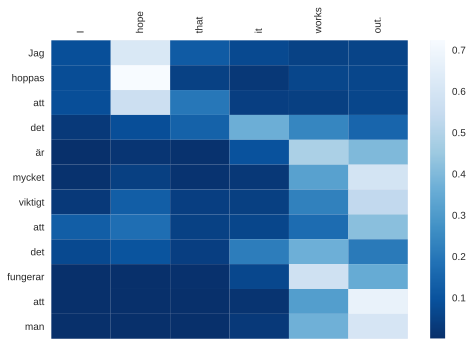

In [88]:
plot_attention(translator, 'I hope that it works out.')

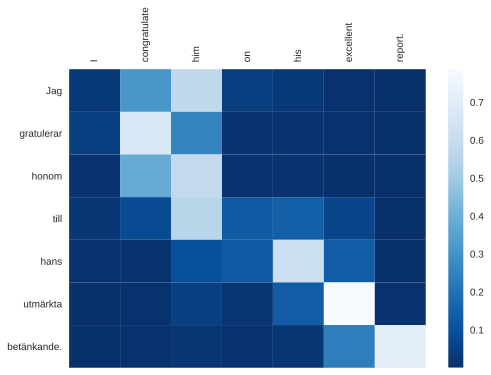

In [89]:
plot_attention(translator, 'I congratulate him on his excellent report.')

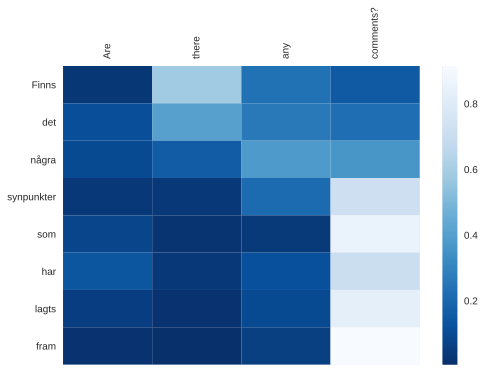

In [95]:
plot_attention(translator, 'Are there any comments?')